### RF forecasting on 2017

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RandomForestModel, RegressionModel
from sklearn.linear_model import LinearRegression
from darts.metrics import mape, mae, rmse
from darts.utils.missing_values import fill_missing_values

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# reindex and ffill
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# fill missing values
series = fill_missing_values(series)

# Create weekly time covariate 
time_vals = pd.Series(np.arange(len(series)), index=series.time_index)
covariate = TimeSeries.from_series(time_vals, freq="W")

# split into train (up to 2012-2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))
train_cov, test_cov = covariate.split_before(pd.Timestamp("2017-01-01"))

full_cov = train_cov.concatenate(test_cov)

# length of forecast horizon
h = len(test_ts)

c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
C:\Users\USER\AppData\Local\Temp\ipykernel_60152\2877795448.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffil

### Linear model

In [44]:
lr = RegressionModel(
    lags=52,
    model=LinearRegression(),
    output_chunk_length=h
)
lr.fit(train_ts)
lr_forecast = lr.predict(n=h, series=train_ts)

### RF model

With past covariates

In [45]:
#    lags_past_covariates=[0] means "use this week's covariate" as a feature
rf = RandomForestModel(
    lags=52,
    #lags_past_covariates=52,
    output_chunk_length=h, # 1 for recusive multi-step forecast, h for direct multi-output forecast
    n_estimators=300,
    random_state=42
)

rf.fit(
    train_ts,
    #past_covariates=train_cov
)

rf_forecast = rf.predict(
    n=h,
    series=train_ts,
    #past_covariates=full_cov
)

In [46]:
# shifting up forcast result
# extract the last training value and the first forecast value
last_train_value     = train_ts.values()[-1, 0]
first_forecast_value = rf_forecast.values()[0, 0]

# compute the additive offset
offset = last_train_value - first_forecast_value

# shift the entire forecast up (or down) by that offset
rf_forecast_shifted = rf_forecast + offset

### Ensemble

In [47]:
# Simple average‐ensemble
ensemble_forecast = (rf_forecast_shifted + lr_forecast) / 2

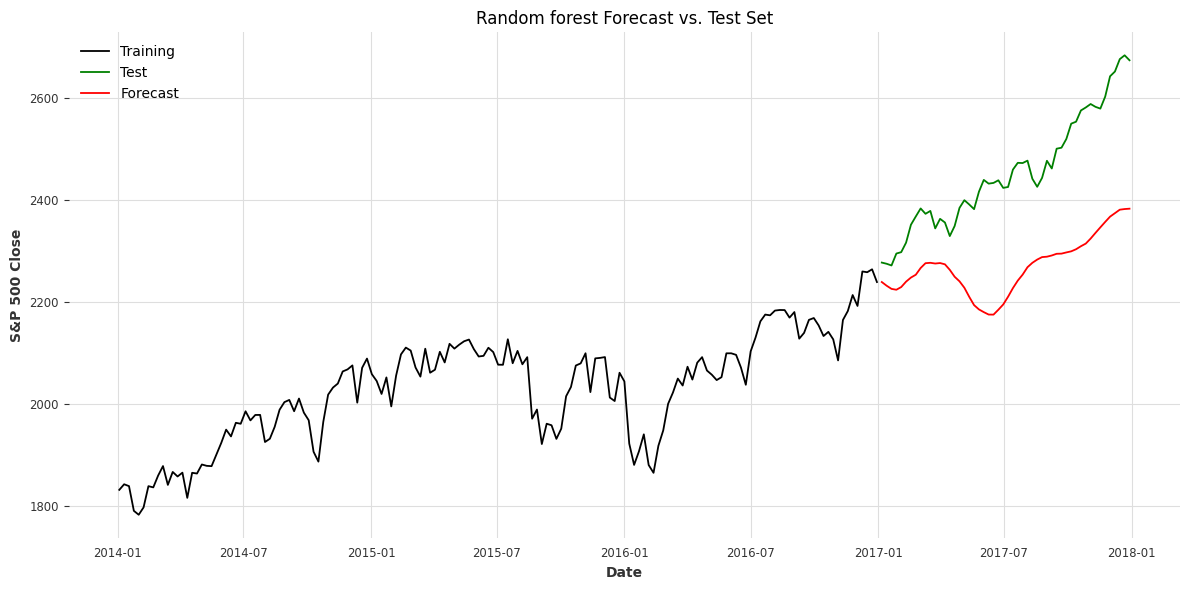

MAPE: 7.32%
MAE:  182.27
RMSE: 198.23


In [49]:
# get only the part of train_ts from 2014-01-01 onward
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())

# plot
plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")
plt.plot(rf_forecast_shifted.time_index, rf_forecast_shifted.values(), label="Forecast", color="red")
plt.title("Random forest Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

# evaluate
print(f"MAPE: {mape(test_ts, rf_forecast_shifted):.2f}%")
print(f"MAE:  {mae(test_ts, rf_forecast_shifted):.2f}")
print(f"RMSE: {rmse(test_ts, rf_forecast_shifted):.2f}")

### Forecast on 2023

In [10]:
# load data
df = sp500.history(start="2014-01-01", end="2024-01-01")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# Fix missing data
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# Create weekly time covariate 
time_vals = pd.Series(np.arange(len(series)), index=series.time_index)
covariate = TimeSeries.from_series(time_vals, freq="W")

# split into train (up to 2012-2022) and test (2023-2024)
train_ts_2, test_ts_2 = series.split_before(pd.Timestamp("2023-01-01"))
train_cov_2, test_cov_2 = covariate.split_before(pd.Timestamp("2017-01-01"))

full_cov_2 = train_cov_2.concatenate(test_cov_2)

# length of forecast horizon
h = len(test_ts_2)

C:\Users\USER\AppData\Local\Temp\ipykernel_60152\1876759320.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


### RF model

In [18]:
#    lags_past_covariates=[0] means "use this week's covariate" as a feature
rf = RandomForestModel(
    lags=52,
    #lags_past_covariates=52,
    output_chunk_length=h, # 1 for recusive multi-step forecast, h for direct multi-output forecast
    n_estimators=300,
    random_state=42
)

rf.fit(
    train_ts_2,
    #past_covariates=train_cov
)

rf_forecast_2 = rf.predict(
    n=h,
    series=train_ts_2,
    #past_covariates=full_cov
)

In [20]:
# shifting up forcast result
# extract the last training value and the first forecast value
last_train_value     = train_ts_2.values()[-1, 0]
first_forecast_value = rf_forecast_2.values()[0, 0]

# compute the additive offset
offset = last_train_value - first_forecast_value

# shift the entire forecast up (or down) by that offset
rf_forecast_shifted_2 = rf_forecast_2 + offset

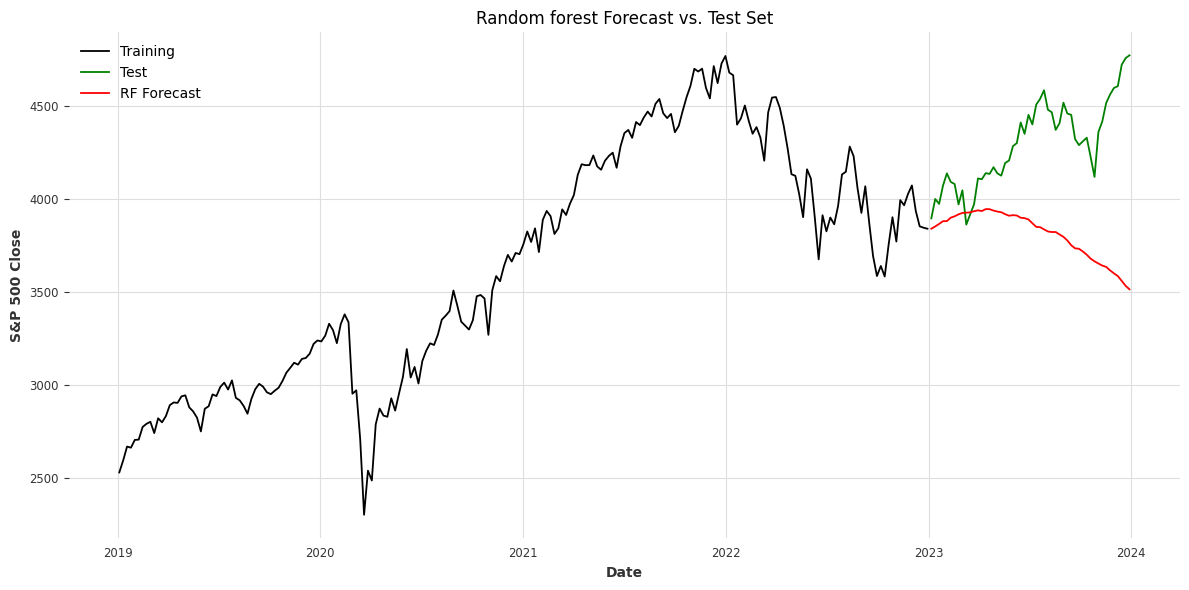

MAPE: 10.90%
MAE:  482.57
RMSE: 580.68


In [ ]:
# get only the part of train_ts from 2016-01-01 onward
train_slice_2 = train_ts_2.slice(pd.Timestamp("2019-01-01"), train_ts_2.end_time())

# plot train, test, and RF forecas
plt.figure(figsize=(12, 6))
plt.plot(train_slice_2.time_index, train_slice_2.values(), label="Training")
plt.plot(test_ts_2.time_index,    test_ts_2.values(),    label="Test",      color="green")
plt.plot(rf_forecast_shifted_2.time_index, rf_forecast_shifted_2.values(), label="RF Forecast", color="red")
plt.title("Random forest Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

# compute metrics
print(f"MAPE: {mape(test_ts_2, rf_forecast_shifted_2):.2f}%")
print(f"MAE:  {mae (test_ts_2, rf_forecast_shifted_2):.2f}")
print(f"RMSE: {rmse(test_ts_2, rf_forecast_shifted_2):.2f}")

### Backtesting

In [78]:
df = sp500.history(start="2016-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

# resample to weekly
weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

C:\Users\USER\AppData\Local\Temp\ipykernel_19760\400281087.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [79]:
# back test period
backtest_start = pd.Timestamp("2023-01-01")
backtest_end   = pd.Timestamp("2024-12-31")

h = len(series[backtest_start:backtest_end])
rf_model_3 = RandomForestModel(
    lags=52,              # one year’s worth of weekly lags
    n_estimators=100,     # number of trees
    random_state=42,
    output_chunk_length=1 # 1-step forecasts
)

rf_model_3.fit(series[:backtest_start])

RandomForestModel(lags=52, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True, random_state=42)

In [83]:
rf_backtest = rf_model_3.historical_forecasts(
    series=series,
    start=backtest_start,
    forecast_horizon=1,      # 1 week ahead
    stride=1,                # move forward one week each time
    retrain=True,            # re-fit at each fold
    last_points_only=True    # keep only the 1-week-ahead point
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


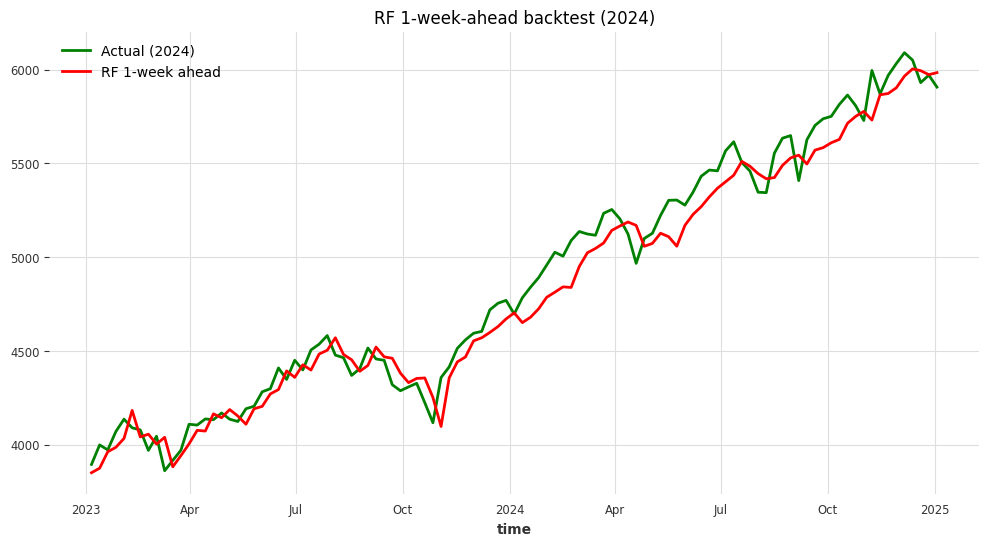

MAPE: 1.95%
MAE:  96.08
RMSE: 113.87


In [84]:
actuals_bt = series[backtest_start:backtest_end]

# plot actual vs RF forecasts
plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2024)", color="green")
rf_backtest.plot(label="RF 1-week ahead", color="red")
plt.legend()
plt.title("RF 1-week-ahead backtest (2024)")
plt.show()

# compute metrics
print(f"MAPE: {mape(actuals_bt, rf_backtest):.2f}%")
print(f"MAE:  {mae(actuals_bt, rf_backtest):.2f}")
print(f"RMSE: {rmse(actuals_bt, rf_backtest):.2f}")

In [85]:
from sklearn.metrics import precision_score

# convert both to pandas Series for easy shifting/alignment
pred = rf_backtest.to_series() # one-week-ahead forecasts
actual = actuals_bt.to_series() # the real weekly closes

# get last week’s actual price at each forecast date
prev_price = actual.shift(1)

# drop the very first point where prev_price is NaN
mask = prev_price.notna()
pred = pred[mask]
actual = actual[mask]
prev_price = prev_price[mask]

# compute predicted & actual directions: +1 for up, -1 for down
pred_dir   = np.where(pred   > prev_price,  1, -1)
actual_dir = np.where(actual > prev_price,  1, -1)

# compute directional accuracy
dir_acc = (pred_dir == actual_dir).mean() * 100
print(f"Directional accuracy: {dir_acc:.2f}%")

# compute precision for the "up" class
y_pred = (pred_dir == 1)
y_true = (actual_dir == 1)
precision = precision_score(y_true, y_pred) * 100
print(f"Precision (stock actually increase): {precision:.2f}%")

Directional accuracy: 43.27%
Precision (stock actually increase): 57.58%
